<a href="https://colab.research.google.com/github/CAVASOL/aiffel_quest/blob/main/Exploration_quest/exploration_5/xp5_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 10-1. 프로젝트: 한국어 데이터로 챗봇 만들기

**Creator: Yeon Kim**

**Goal**

* 공백 및 특수문자 처리, 토크나이징, 병렬데이터 구축 등의 전처리 과정을 진행합니다.
* 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 진행합니다.
* 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현합니다.

**Index**

    Set up
    Step 1. 데이터 수집하기
    Step 2. 데이터 전처리하기
    Step 3. SubwordTextEncoder 사용하기
    Step 4. 모델 구성하기
        Positional Encoding
        Scaled Dot-Product Attention
        Multi-head Attention
        Masking
        Encoder
        Decoder
        Design Transformer
        
    Step 5. 모델 평가하기
    
    Conclusion
      Details
      Result
      Retrospect
      Reference

### Set up

In [ ]:
import os
import re
import sys

import numpy as np
import random
import pandas as pd
import itertools
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

# import torch
# import torch.nn.functional as F

# from torch import nn, optim
# from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print("tensorflow", tf.__version__)

tensorflow 2.6.0


### Step 1. 데이터 수집하기

**Dataset Details:** [songys / Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

In [ ]:
# mkdir -p ~/aiffel/transformer_chatbot/data/
# ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

In [ ]:
data_df = pd.read_csv('/aiffel/data/ChatbotData .csv')

print("Data shape:", data_df.shape)

Data shape: (11823, 3)


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [ ]:
display(data_df.head(5))

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


### Step 2. 데이터 전처리하기

In [ ]:
data_df.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [ ]:
data_df = data_df[['Q', 'A']]
data_df.head()

data_df.sample(5)

,Q,A
8911,갑자기 선을 긋는 사람,너무 사적 영역으로 들어왔나봅니다.
5144,혼자 살고 싶다,혼자 사는 것도 나쁘지 않아요.
11426,짝남이랑 사귀기로 했어,축하드려요.
3949,자주 못보면 헤어지겠제?,장거리 연애 힘들겠죠.
4281,지금 자면 밤에 못 자겠지?,낮잠은 20분만 자세요.


In [ ]:
print('Q 열에서 중복을 배제한 유일한 샘플의 수 :', data_df['Q'].nunique())
print('A 열에서 중복을 배제한 유일한 샘플의 수 :', data_df['A'].nunique())

Q 열에서 중복을 배제한 유일한 샘플의 수 : 11662
A 열에서 중복을 배제한 유일한 샘플의 수 : 7779


In [ ]:
Q, A = list(data_df['Q']), list(data_df['A'])

입력받은 sentence의 양쪽 공백을 제거한 후, `한글 / . / , / ? / !`를 제외한 모든 문자를 공백인 `" "` 로 대체합니다.

In [ ]:
def preprocess_sentence(sentence):
  sentence = sentence.strip()

  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

### Step 3. SubwordTextEncoder 사용하기

각 단어에 고유한 정수 인덱스를 부여하기 위해 `Q`와 `A` 데이터를 모두 사용하여 단어장 `Vocabulary`를 만듭니다.

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(Q+A, target_vocab_size=2**13)

디코더의 문장 생성 과정에서 사용할 `시작 토큰`과 `종료 토큰`에 대해서도 임의로 단어장에 추가하여 정수를 부여합니다.  
이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기보다 `1`이 큰 수를 번호로 부여합니다.

In [ ]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

`시작 토큰`과 `종료 토큰`에 부여된 정수를 출력해 봅시다.

In [ ]:
print('START_TOKEN:' ,[tokenizer.vocab_size])
print('END_TOKEN:' ,[tokenizer.vocab_size + 1])

START_TOKEN: [8170]
END_TOKEN: [8171]


각각 `8,170`과 `8,171`라는 점에서 현재 단어장의 크기가 `8,170(0번부터 8,170번)` 임을 알 수 있습니다.  
`시작 토근`과 `종료 토큰` 두 개의 토큰을 추가해 주었으므로 `단어장의 크기도 +2 임`을 명시해 주어야 합니다.

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size + 2

print("Size of Vocab", VOCAB_SIZE)

Size of Vocab 8172


위에서 `tensorflow_datasets`의 `SubwordTextEncoder`를 사용해서 `tokenizer`를 정의하고 Vocabulary를 만들었습니다.  
tokenizer.encode()로 각 단어를 정수로 변환할 수 있고, tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.  
88번째 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과를 확인해 봅시다.

In [ ]:
print('Question sample after integer encoding: {}'.format(tokenizer.encode(Q[87])))
print('Answer sample after integer encoding: {}'.format(tokenizer.encode(A[87])))

Question sample after integer encoding: [5730, 12, 1111, 1508]
Answer sample after integer encoding: [240, 369, 377, 619, 2348, 7960]


각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있습니다.  
위의 결과와 마찬가지로 Q와 A 페어에 대해서 전부 정수 인코딩을 수행합니다.  
이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 padding 합니다.

In [ ]:
MAX_LENGTH = 30

print("Maximum length of sentence:", MAX_LENGTH)

Maximum length of sentence: 30


In [ ]:
# Integer encoding, removing samples exceeding maximum length & padding
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # Add start token and end token during integer encoding process
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # Accepted as a dataset only if the maximum length is 40 or less.
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # Padding all datasets to a maximum length of 30
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

정수 인코딩 과정을 수행하면서 샘플의 길이가 30을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외되었습니다.  
단어장의 크기와 샘플의 개수를 확인해 봅시다.

In [ ]:
Q, A = tokenize_and_filter(Q, A)
print('Size of Vocabulary :',(VOCAB_SIZE))
print('Number of sample questions after filtering: {}'.format(len(Q)))
print('Number of sample answers after filtering: {}'.format(len(A)))

Size of Vocabulary : 8172
Number of sample questions after filtering: 11822
Number of sample answers after filtering: 11822


질문과 답변 페어를 `tf.data.Dataset API`의 입력으로 사용하여 파이프라인을 구성합니다.    
이 때, `Teacher Forcing`을 위해서 `answers[:, :-1]`를 디코더의 입력값, `answers[:, 1:]`를 디코더의 레이블로 사용합니다.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# The decoder uses the previous target as the next input.
# Accordingly, remove START_TOKEN from outputs.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': Q,
        'dec_inputs': A[:, :-1]
    },
    {
        'outputs': A[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Step 4. 모델 구성하기

### Positional Encoding

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # Create an array of angles
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # Apply sin function to even indices of array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # Apply cosine function to odd indices of array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # Rearrange sin and cosine so that they intersect
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("Gotcha")

Gotcha


### Scaled Dot-Product Attention

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):

  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # normalize the weights
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # Add mask to padding
  if mask is not None:
    logits += (mask * -1e9)

  # softmax
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # The final attention is the weight and the dot product of V.
  output = tf.matmul(attention_weights, value)
  return output

### Multi-head Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q. Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # Q. 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # Scaled dot-product attention function
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # After the attention operation, each result is concatenated again.
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # Apply Dense once more to the final result
    outputs = self.dense(concat_attention)

    return outputs

### Masking

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### Encoder

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # Multi-head attention (self-attention)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # Dropout and LayerNormalization are performed on the results of attention.
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # Two fully connected layers
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # Dropout and LayerNormalization are performed on the results of the fully connected layer.
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Decoder

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # Multi-head attention (self-attention)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # The result of multi-head attention performs LayerNormalization.
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # Masked Multi-head attention (encoder-decoder attention)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # The result of Masked Multi-head attention performs Dropout and LayerNormalization.
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # Two fully connected layers
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # Dropout and LayerNormalization are performed on the results of the fully connected layer.
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### Design Transformer

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # Mask for padding in the encoder
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # Used by the decoder to mask future tokens.
  # A padded mask is also included internally.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # Masking the vectors of the encoder in the second attention block
  # Mask for padding in the decoder
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # Encoder
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # Decoder
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # Fully connected layer
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2
D_MODEL = 256 # Fixed dimensionality of input and output inside encoder and decoder
NUM_HEADS = 8 # Number of heads in multi-head attention
UNITS = 512 # Size of hidden layer in feed forward neural network
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용합니다.

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

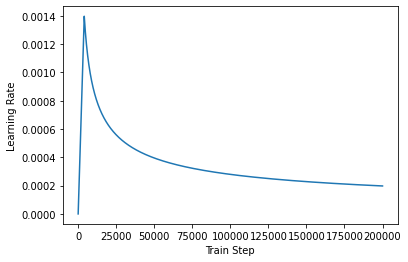

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

손실 함수와 커스텀 된 learning rate를 사용하여 모델을 컴파일합니다.

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 50

history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 15s 46ms/step - loss: 1.9531 - accuracy: 0.0398
Epoch 2/50
185/185 [==============================] - 9s 46ms/step - loss: 1.5802 - accuracy: 0.0666
Epoch 3/50
185/185 [==============================] - 9s 47ms/step - loss: 1.3471 - accuracy: 0.0685
Epoch 4/50
185/185 [==============================] - 9s 47ms/step - loss: 1.2449 - accuracy: 0.0733
Epoch 5/50
185/185 [==============================] - 9s 46ms/step - loss: 1.1683 - accuracy: 0.0775
Epoch 6/50
185/185 [==============================] - 9s 46ms/step - loss: 1.0887 - accuracy: 0.0832
Epoch 7/50
185/185 [==============================] - 9s 46ms/step - loss: 0.9997 - accuracy: 0.0914
Epoch 8/50
185/185 [==============================] - 8s 46ms/step - loss: 0.9022 - accuracy: 0.1018
Epoch 9/50
185/185 [==============================] - 8s 46ms/step - loss: 0.7959 - accuracy: 0.1136
Epoch 10/50
185/185 [==============================] - 9s 46ms/step - loss: 0.6834 - accur

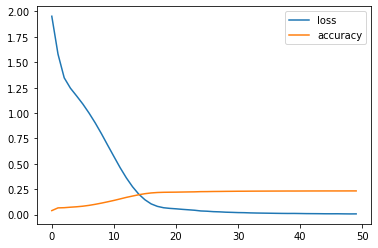

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

### Step 5. 모델 평가하기

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # After encoding the input sentence as an integer, add the start token and end token back and forth.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # A variable in which the current predicted output sequence of the decoder is persistently stored.
  # Since there is no prediction at first, only the starting token is stored separately. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # Inference stage of the decoder
  for i in range(MAX_LENGTH):
    # The decoder repeats next word prediction up to a length of MAX_LENGTH.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # Integer of the currently predicted word
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # If the currently predicted word is a termination token, terminate the for statement.
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # Predicted words are continuously added to output_sequence
    # This output_sequence again becomes the input to the decoder.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence):
  # The decoder is operated on the input sentence and a predicted integer sequence is returned.
  prediction = decoder_inference(sentence)

  # Converts a sequence of integers back to a text sequence.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input : {}'.format(sentence))
  print('Output : {}'.format(predicted_sentence))

  return predicted_sentence

## Conclusion

### Details

한국어 챗봇을 위해 영어 챗봇 모델을 한국어 데이터로 변환하는 실험의 과정은 다음과 같습니다. `한국어 챗봇 데이터`를 수집하여 전처리하고, `SubwordTextEncoder`를 활용하여 토큰화합니다. 이후, `트랜스포머 모델`을 구현하고 학습시킨 후, 적절한 예측 함수를 통해 입력된 문장에 대한 응답을 생성하고 모델을 평가합니다. 이를 통해 한국어에 적합한 챗봇 모델을 구축하고, 테스트하여 결과를 확인했습니다.

### Result

In [ ]:
sentence_generation('넌 누구야?')

Input : 넌 누구야?
Output : 사람마다 다르겠지만 사귀고 난 후가 좋겠어요.


'사람마다 다르겠지만 사귀고 난 후가 좋겠어요.'

In [ ]:
sentence_generation('오늘 너무 춥다.')

Input : 오늘 너무 춥다.
Output : 최근에 이별을 하셨나보군요.


'최근에 이별을 하셨나보군요.'

`duh, you re a weirdo .`

### Retrospect

>한국어 쳇봇 데이터셋을 활용하여 전처리하고, 토큰화한 후 트랜스포머 모델을 구현하는 작업이 흥미로웠습니다. 직접 모델을 구현하지는 못 했고, 설계된 모델을 이해하는 것도 어려웠습니다. 멀티 헤드 어텐션의 개념이 새로웠고, 퍼포먼스를 이해하기 위해 다양한 자료를 참고했습니다. 영어 텍스트와 한글 텍스트의 전처리 과정이 어떻게 다른지 실험을 통해 복습할 수 있어서 유익했고, 트랜스포머의 퍼포먼스를 관찰하며 배울 수 있었습니다. 모델 학습 시 손실을 최대한 낮추도록 에폭을 조정한 후 시각화하여 확인했습니다. 손실이 0에 가까울 수록 임의의 질문에 대한 대답이 좀 더 적절하게 도출되는 것을 관찰할 수 있었어요. 한국어 데이터셋을 활용하여 쳇봇을 구현한 다양한 작품들이 PyTorch를 활용했다는 사실을 알게 되었고, PyTorch를 활용한 모델 구성과 검증에 대해 살펴봤습니다. 자연스러운 대화가 가능한 쳇봇을 구현하기 위해서는 정말 세심한 작업이 필요하겠구나 생각해 볼 수 있었어요.

### Reference

**Transformer Chatbot**

* [What is a Deep Learning Chatbot?](https://shanebarker.com/blog/deep-learning-chatbot/)  
* [A Transformer Chatbot Tutorial with TensorFlow 2.0](https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html)  
* [Small Transformer for Korean chatbot (pytorch)](https://www.kaggle.com/code/fleek12/small-transformer-for-korean-chatbot-pytorch)  
* [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)  
* [What are Encoder in Transformers](https://www.scaler.com/topics/nlp/transformer-encoder-decoder/)  
* [Transformers-based Encoder-Decoder Models](https://huggingface.co/blog/encoder-decoder)
* [The Transformer Attention Mechanism](https://machinelearningmastery.com/the-transformer-attention-mechanism/)  
* [Transformer: A Novel Neural Network Architecture for Language Understanding](https://blog.research.google/2017/08/transformer-novel-neural-network.html)
* [How to Implement Scaled Dot-Product Attention from Scratch in TensorFlow and Keras](https://machinelearningmastery.com/how-to-implement-scaled-dot-product-attention-from-scratch-in-tensorflow-and-keras/)
* [Hugging Face - T5, num_heads](https://huggingface.co/transformers/v3.0.2/model_doc/t5.html)  
* [Transformers Explained Visually (Part 3): Multi-head Attention, deep dive](https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853)  
* [TensorFlow - tf.keras.layers.MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)  
* [TensorFlow - Understanding masking & padding](https://www.tensorflow.org/guide/keras/understanding_masking_and_padding)  
* [TensorFlow - Module: tf.keras.preprocessing.sequence](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence)  
* [TensorFlow - tf.keras.utils.pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences)  
* [TensorFlow - Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer)  
* [Cornell Univ. - Cornell Movie-Dialogs Corpus Dataset](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)  
* [Cornell Movie-Dialogs Corpus Dataset Details](https://convokit.cornell.edu/documentation/movie.html)  

**Korean Chatbot**

* [hyunwoongko / kochat](https://github.com/hyunwoongko/kochat)  
* [jyujin39 / Korean_Chatbot_Model](https://github.com/jyujin39/Korean_Chatbot_Model)  
* [kooyunmo / diya-chat](https://github.com/kooyunmo/diya-chat)